In [1644]:
import torch
import torch.nn as nn			#帮助我们创建和训练神经网络
from torch.optim import SGD		#导入实现随机梯度下降算法
import torch.utils.data as Data	#导入数据集
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt		#用于制图

In [1645]:
df = pd.read_csv('new_data.csv')
df = df.sample(frac=1)
# 数据预处理归一化
# df = df.apply(lambda x : (x - x.mean()) / x.std())
all_features = df.drop(columns="Fiber Diameter")
n_train = int(len(df) * 0.8)

In [1646]:
df.shape

(87, 5)

In [1647]:
train_features = torch.from_numpy(all_features[:n_train].values.astype(np.float32))
test_features = torch.from_numpy(all_features[n_train:].values.astype(np.float32))
train_labels = torch.from_numpy(df[:n_train]["Fiber Diameter"].values.reshape(-1, 1).astype(np.float32))

In [1648]:
# 定义网络模型
class myMLP(nn.Module):
    def __init__(self):
        super(myMLP, self).__init__()
        # 定义隐藏层
        self.layer0 = nn.Sequential(
            nn.Linear(4, 4),
            nn.BatchNorm1d(4),
            nn.ReLU()
        )
        # self.layer1 = nn.Sequential(
        #     nn.Linear(4, 4),
        #     nn.BatchNorm1d(4),
        #     nn.ReLU()
        # )
        # self.layer2 = nn.Sequential(
        #     nn.Linear(8, 8),
        #     nn.BatchNorm1d(8),
        #     nn.ReLU()
        # )
        # self.layer3 = nn.Sequential(
        #     nn.Linear(8, 8),
        #     nn.BatchNorm1d(8),
        #     nn.ReLU()
        # )
        self.regression = nn.Linear(4, 1)

    def forward(self, x):
        x = self.layer0(x)
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        x = self.regression(x)
        return x

net = myMLP()

In [1649]:
loss = nn.MSELoss()
def log_rmse(net, features, labels, device):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    net = net.to(device)
    features, labels = features.to(device), labels.to(device)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [1650]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size, device):
    train_ls, test_ls = [], []
    train_data = Data.TensorDataset(train_features, train_labels)
    train_loader = Data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels, device))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels, device))
    return train_ls, test_ls


In [1651]:
# k折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [1652]:
# k折交叉验证 训练
def k_fold_train(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size, device):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = myMLP()
        train_ls, valid_ls = train(net, *data, num_epochs, lr,
                                weight_decay, batch_size, device)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls, 'b')
            plt.plot(list(range(1, num_epochs + 1)), valid_ls, 'r')
            plt.xlabel('epochs')
            plt.legend(['train ls', 'valid ls'])
        print(f'折{i + 1}，训练log rmse {float(train_ls[-1]):f}, 验证log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k , valid_l_sum / k

折1，训练log rmse 0.197125, 验证log rmse 0.231808
折2，训练log rmse 0.177033, 验证log rmse 0.202685
折3，训练log rmse 0.160863, 验证log rmse 0.262373
折4，训练log rmse 0.181783, 验证log rmse 0.231133
折5，训练log rmse 0.186112, 验证log rmse 0.200671
5-折验证: 平均训练log rmse: 0.180583, 平均验证log rmse: 0.225734


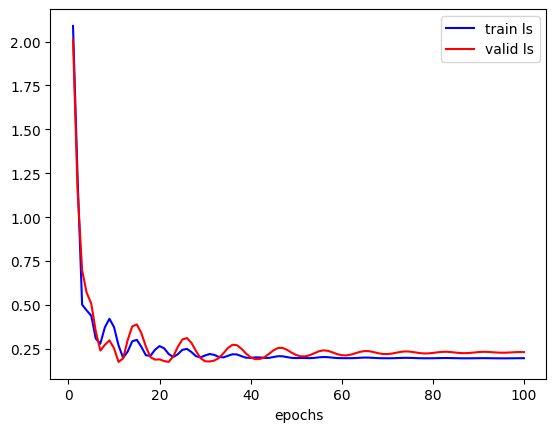

In [1653]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 3, 0.02, 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_l, valid_l = k_fold_train(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size, device)

print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [1654]:
# def train_and_pred(train_features, test_features, num_epochs,)

In [1655]:
'''
5, 30, 3, 0.01, 32  平均训练log rmse: 0.186586, 平均验证log rmse: 0.217087
5, 50, 3, 0.01, 32  平均训练log rmse: 0.190420, 平均验证log rmse: 0.256316
5, 100, 3, 0.01, 32 平均训练log rmse: 0.170849, 平均验证log rmse: 0.224346 
5, 100, 3, 0.01, 64 平均训练log rmse: 0.159398, 平均验证log rmse: 0.219554 
5, 100, 3, 0.01, 128平均训练log rmse: 0.155570, 平均验证log rmse: 0.230259
5, 100, 5, 0.01, 64 平均训练log rmse: 0.172077, 平均验证log rmse: 0.215775
5, 100, 3, 0.02, 64 平均训练log rmse: 0.172697, 平均验证log rmse: 0.200386

'''

'\n5, 30, 3, 0.01, 32  平均训练log rmse: 0.186586, 平均验证log rmse: 0.217087\n5, 50, 3, 0.01, 32  平均训练log rmse: 0.190420, 平均验证log rmse: 0.256316\n5, 100, 3, 0.01, 32 平均训练log rmse: 0.170849, 平均验证log rmse: 0.224346 \n5, 100, 3, 0.01, 64 平均训练log rmse: 0.159398, 平均验证log rmse: 0.219554 \n5, 100, 3, 0.01, 128平均训练log rmse: 0.155570, 平均验证log rmse: 0.230259\n5, 100, 5, 0.01, 64 平均训练log rmse: 0.172077, 平均验证log rmse: 0.215775\n5, 100, 3, 0.02, 64 平均训练log rmse: 0.172697, 平均验证log rmse: 0.200386\n\n'